# Layout LM

LayoutLM is a Neural Network that jointly models interactions between text and layout information across scanned document images, thus is beneficial for a great number of real-world document image understanding tasks such as information extraction from scanned documents.

Basically, there are two types of features which substantially improve the language representation in a visually rich document, which are:
1. Document Layout Information
2. Visual Information

## Architecture Details

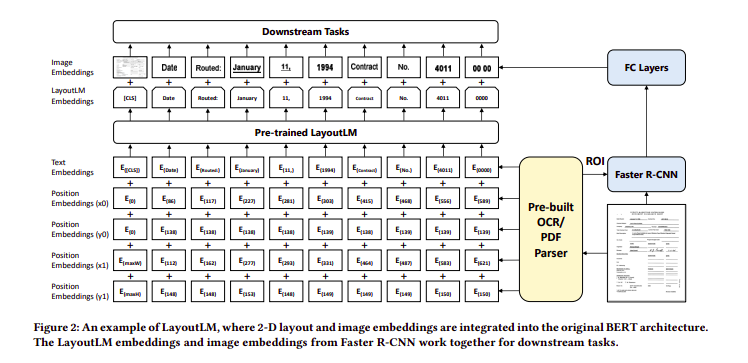

To take advantage of existing pre-trained models and adapt to document image understanding tasks, we use the BERT architecture as the backbone and add two new input embeddings: a 2-D position embedding and an image embedding.

**2-D Position Embedding**: Unlike the position embedding that models the word position in a sequence, 2-D position embedding aims to model the relative spatial position in a document. To represent the spatial position of elements in scanned document images, we consider a document page as a coordinate system with the topleft origin. In this setting, the bounding box can be precisely defined by (x0, y0, x1, y1), where (x0, y0) corresponds to the position of the upper left in the bounding box, and (x1, y1) represents the position of the lower right. We add four position embedding layers with two embedding tables, where the embedding layers representing the same dimension share the same embedding table. This means that we look up the position embedding of x0 and x1 in the embedding table X and lookup y0 and y1 in table Y.

**Image Embedding**: To utilize the image feature of a document and align the image feature with the text, we add an image embedding layer to represent image features in language representation. In more detail, with the bounding box of each word from OCR results,we split the image into several pieces, and they have a one-to-one
correspondence with the words. We generate the image region features with these pieces of images from the Faster R-CNN model as the token image embeddings. For the [CLS] token, we also use the Faster R-CNN model to produce embeddings using the whole scanned document image as the Region of Interest (ROI) to benefit the downstream tasks which need the representation of the [CLS] token.

## Pre-Trained Layout LM

**Masked Visual-Language Model**: Inspired by the masked language model, the Masked Visual-language Model (MVLM) learns the language representation with the clues of 2-D position embeddings and text embeddings. During the pre-training, we randomly mask some of the input tokens but keep the corresponding 2-D position embeddings, and then the model is trained to predict the masked tokens given the contexts. In this way, the LayoutLM model not only understands the language contexts but also utilizes the corresponding 2-D position information, thereby bridging the gap between the visual and language modalities.

**Multi-label Document Classification**: For document image understanding, many tasks require the model to generate highquality document-level representations. As the IIT-CDIP Test Collection includes multiple tags for each document image, LayoutLM uses a Multi-label Document Classification (MDC) loss during the pre-training phase. Given a set of scanned documents, we use the document tags to supervise the pre-training process so that the model can cluster the knowledge from different domains and generate better document-level representation. Since the MDC loss needs the label for each document image that may not exist for larger datasets, it is optional during the pre-training and may not be used for pre-training larger models in the future. 

The layoutLM model is pre-trained on the IIT-CDIP Test Collection 1.0, which contains more than 6 million documents, with more than 11 million scanned document images.

## Fine Tuned Layout LM
The pre-trained LayoutLM model is fine-tuned on three document image understanding tasks, including a form understanding task, a receipt understanding task as well as a document image classification task. 

For the form and receipt understanding tasks, LayoutLM predicts {B, I, E, S, O} tags for each token and uses sequential labeling to detect each type of entity in the dataset. SROIE Dataset is used for the purpose

For the document image classification task, LayoutLM predicts the class labels using the representation of the [CLS] token. The FUNSD Dataset and the RVL-CDIP Dataset are used for this purpose

**Reference**

LayoutLM: Pre-training of Text and Layout for Document Image Understanding paper: [1912.13318](https://arxiv.org/pdf/1912.13318.pdf)


**Note**: 

The existing model only provides the language model, i.e. the LayoutLM embeddings, and not the final layers which combine visual features.

In [1]:
import numpy as np
from transformers import LayoutLMTokenizer, LayoutLMForTokenClassification
import torch
from PIL import Image, ImageDraw, ImageFont

# Doc Classification Training 

WIP

# Doc Classification Inference
WIP

# NER Training
WIP

# NER Inference

In [2]:
tokenizer = LayoutLMTokenizer.from_pretrained("tanay/layoutlm-funsd")
model = LayoutLMForTokenClassification.from_pretrained("tanay/layoutlm-funsd")

labels = ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']

labels = ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']
id2label = {v: k for v, k in enumerate(labels)}
label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/430M [00:00<?, ?B/s]

In [3]:
from datasets import load_dataset
dataset = load_dataset("nielsr/funsd")

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset funsd downloaded and prepared to /root/.cache/huggingface/datasets/nielsr___funsd/funsd/1.0.0/8b0472b536a2dcb975d59a4fb9d6fea4e6a1abe260b7fed6f75301e168cbe595. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
query_index = 0
words = dataset['test'][query_index]['words']
normalized_word_boxes = dataset['test'][query_index]['bboxes']

In [5]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]
    
def iob_to_label(label):
    label = label[2:]
    if not label:
        return 'other'
    return label    
    
img = Image.open(dataset['test'][query_index]['image_path'])    
W, H = img.size    
bboxes = [unnormalize_box(box, W, H) for box in normalized_word_boxes]    

In [6]:
token_boxes = []
for word, box in zip(words, normalized_word_boxes):
    word_tokens = tokenizer.tokenize(word)
    token_boxes.extend([box] * len(word_tokens))
# add bounding boxes of cls + sep tokens
token_boxes = [[0, 0, 0, 0]] + token_boxes + [[1000, 1000, 1000, 1000]]

encoding = tokenizer(" ".join(words), return_tensors="pt")
bbox = torch.tensor([token_boxes])

outputs = model(
    input_ids=encoding["input_ids"],
    bbox=bbox,
    attention_mask=encoding["attention_mask"],
    token_type_ids=encoding["token_type_ids"],
)

preds = torch.nn.functional.softmax(outputs.logits, dim=2).cpu().detach().numpy()
preds_idx = preds.argmax(axis=2)[0]
preds_labels = [labels[idx] for idx in preds_idx]

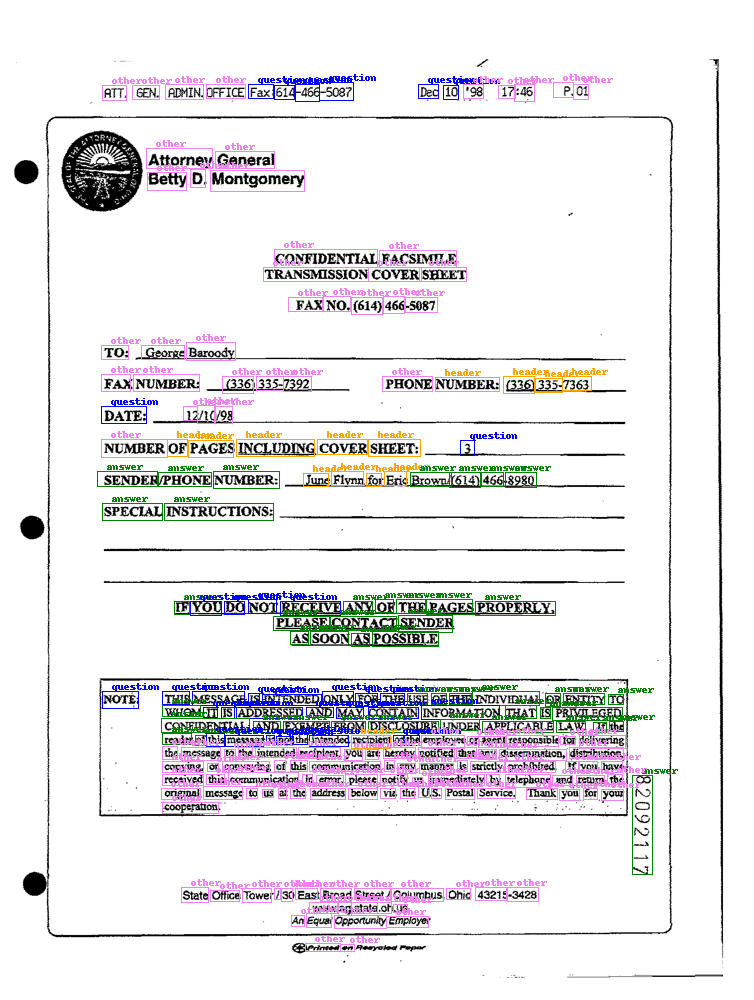

In [7]:
img_rgb = img.convert('RGB')
draw = ImageDraw.Draw(img_rgb)
font = ImageFont.load_default()

for label, box in zip(preds_labels, bboxes):
    label = iob_to_label(label).lower()
    draw.rectangle(box, outline=label2color[label])
    draw.text((box[0]+10, box[1]-10), text=label, fill=label2color[label], font=font)
img_rgb